In [1]:
import tensorflow as tf
import numpy as np
import os
import sys

In [2]:
# Path para importacion de funciones
dir_actual    = os.path.abspath('')
dir_parent = os.path.dirname(dir_actual)
if not dir_parent in sys.path: sys.path.append(dir_parent)

## Loading CIFAR10 Data

In [3]:
(_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Normalizando
x_test = x_test/255.
# Reducing Target innecessary dimension
y_test  = np.squeeze(y_test)

## Creating Dataset Objects

In [4]:
from functions import to_categorical, AlexNet_resize

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(to_categorical)
test_dataset = test_dataset.map(AlexNet_resize)
test_dataset = test_dataset.batch(1)

## Loading Quantized model and Non Quantized model 

En base al resultado del ultimo item del cuaderno "AlexNet Analysis" las entradas/salidas de las capas tienen valores que varian entre -80 y 53.5, aunque los valores maximos y minimos varian enormemente entre capas, por ahora realizaremos una cuantizacion igual para cada capa.

In [5]:
from models import AlexNet_body

input_layer   = tf.keras.Input((227,227,3))
output_layer  = AlexNet_body(input_layer, Quantization = False)

Frac_Bits = 4
Int_Bits  = 7

Qinput_layer  = tf.keras.Input((227,227,3))
Qoutput_layer = AlexNet_body(Qinput_layer, Quantization = True, word_size = (Frac_Bits+Int_Bits+1), frac_size = Frac_Bits)

AlexNet  = tf.keras.Model(inputs=input_layer, outputs=output_layer)
QAlexNet = tf.keras.Model(inputs=Qinput_layer, outputs=Qoutput_layer)

## Loading Pretrained Weights

In [6]:
# Loading Wieghts
cwd = os.getcwd()
Wgt_dir = os.path.join(cwd,'TrainedWeights')
Wgt_dir = os.path.join(Wgt_dir,'Weights')

AlexNet.load_weights(Wgt_dir)
QAlexNet.load_weights(Wgt_dir)

## Quantize weights

En base al resultado del ultimo item del cuaderno "AlexNet Analysis" los valores de los pesos varian entre -0.16 y 28.7, en este caso, en general no hay grandes variaciones entre valores por capa.

Obs: vale la pena notar que dado que el minimo de los pesos es muy cercano a 0, puede la cuantizacion sin signo ser una alternativa, ademas salvo una capa de batchnormalization con pesos de altos valores (28.7 y otros), los demas pesos se mantienen de baja magnitud (menor a 8 y en su gran mayoria menor a 2)

In [7]:
from models import Weight_Quantization
Weight_Quantization(model = QAlexNet, Frac_Bits = 8, Int_Bits = 5)

## Check the general Accuracy

In [8]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
AlexNet.compile(optimizer=optimizer, loss=loss, metrics=metrics)
QAlexNet.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Original model

In [20]:
AlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 62s 6ms/step - loss: 0.6316 - accuracy: 0.7898


[0.6315659527876948, 0.7898]

# Experimento 1: Cuantizacion homogenea (pesos y activaciones), sin saturacion

### 5 bits de precision 

In [21]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 60s 6ms/step - loss: 6.1661 - accuracy: 0.4053


[6.166052489484474, 0.4053]

### 6 bits de precision

In [15]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 61s 6ms/step - loss: 1.0707 - accuracy: 0.7398 0s - loss: 1.0708 - accuracy: 0.73


[1.0706737461386249, 0.7398]

### 7 bits de precision

In [21]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 59s 6ms/step - loss: 0.8646 - accuracy: 0.7533


[0.8646249719636515, 0.7533]

### 8 bits de precision

In [26]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 60s 6ms/step - loss: 0.6723 - accuracy: 0.7935


[0.6723387817996089, 0.7935]

Se necesitan al menos 6 bits para tener resultados decentes, luego de 8 bits se alcanza al modelo original

# Experimento 2: variacion en precision de pesos y activaciones por separado

### 7 bits de precision  para pesos && 8 bits de precision para activaciones

In [32]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 60s 6ms/step - loss: 0.8119 - accuracy: 0.7537


[0.8118756652813406, 0.7537]

### 8 bits de precision para pesos && 7 bits de precision para activaciones

In [38]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 60s 6ms/step - loss: 0.6994 - accuracy: 0.7938


[0.6994086616043934, 0.7938]

### 8 bits de precision para pesos && 6 bits de precision para activaciones

In [10]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 64s 6ms/step - loss: 0.7647 - accuracy: 0.7947


[0.7646517137991266, 0.7947]

### 8 bits de precision para pesos && 5 bits de precision para activaciones

In [26]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 60s 6ms/step - loss: 0.8503 - accuracy: 0.7945


[0.8503479480508714, 0.7945]

### 8 bits de precision para pesos && 4 bits de precision para activaciones

In [21]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 60s 6ms/step - loss: 1.0048 - accuracy: 0.7924


[1.0048045276381075, 0.7924]

### 8 bits de precision para pesos && 3 bits de precision para activaciones

In [26]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 60s 6ms/step - loss: 1.4013 - accuracy: 0.7796


[1.401272422876954, 0.7796]

### 8 bits de precision para pesos && 2 bits de precision para activaciones

In [10]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 62s 6ms/step - loss: 3.7763 - accuracy: 0.6186


[3.776289973831177, 0.6186]

La precicion de los pesos es mucho mas importante, se alcanzan excelentes resultados incluso con 3 bits de precicion para activaciones

# Experimento 3: Variacion en el numero de bits para la parte entera de los pesos (presicion de 8 bits tanto para pesos y 4 para activaciones )

### 4 bits para parte entera pesos

In [10]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 64s 6ms/step - loss: 1.0091 - accuracy: 0.7921


[1.0091007089659572, 0.7921]

### 3 bits para parte entera pesos

In [15]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 65s 7ms/step - loss: 1.0180 - accuracy: 0.7853


[1.0180256422705949, 0.7853]

### 2 bits para parte entera pesos

In [30]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 64s 6ms/step - loss: 1.0887 - accuracy: 0.7723


[1.0887096228919924, 0.7723]

### 1 bit para parte entera pesos

In [10]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 61s 6ms/step - loss: 1.4661 - accuracy: 0.7454


[1.466126222857833, 0.7454]

# Experimento 4: Variacion en el numero de bits para la parte entera de las activaciones (presicion de 8 bits tanto para pesos y 4 para activaciones )

### 6 bits para parte entera activaciones

In [18]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 66s 7ms/step - loss: 1.0048 - accuracy: 0.7924


[1.0048045276381075, 0.7924]

### 5 bits para parte entera activaciones

In [23]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 65s 7ms/step - loss: 1.0048 - accuracy: 0.7923


[1.0048096896000207, 0.7923]

### 4 bits para parte entera activaciones

In [15]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 62s 6ms/step - loss: 0.9866 - accuracy: 0.7937


[0.986574599121511, 0.7937]

### 3 bits para parte entera activaciones

In [24]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 63s 6ms/step - loss: 0.9117 - accuracy: 0.7778


[0.9116993742294609, 0.7778]

4 bits para la parte entera de las activaciones y 3 para la de los pesos son suficientes

# Experimento 5: variacion en la precision de los pesos en las capas FC

### 6 bits de precision pesos capas full conectadas

In [32]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 63s 6ms/step - loss: 1.0354 - accuracy: 0.7918


[1.0354409900657833, 0.7918]

### 5 bits de precision pesos capas full conectadas

In [10]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 62s 6ms/step - loss: 1.2250 - accuracy: 0.7896


[1.2250263604424894, 0.7896]

### 4 bits de precicion pesos capas full conectadas

In [15]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 62s 6ms/step - loss: 1.2114 - accuracy: 0.7336


[1.2113528115950525, 0.7336]

# Experimento 6: variacion en la parte entera de los pesos en las capas FC

### 2 bits parte entera pesos capas fc

In [27]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 64s 6ms/step - loss: 1.0048 - accuracy: 0.7924


[1.0048045276381075, 0.7924]

### 1 bits parte entera pesos capas fc

In [10]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 63s 6ms/step - loss: 1.0048 - accuracy: 0.7924


[1.0048045276381075, 0.7924]

### 0 bits parte entera pesos capas fc

In [15]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 60s 6ms/step - loss: 1.0048 - accuracy: 0.7924


[1.0048045276381075, 0.7924]

# Resumen de las mejores combinaciones

### Pesos capas no FC: precicion = 8, parte entera = 3.  
### Pesos capas FC: precicion = 5, parte entera = 0.
### Activaciones:    precicion = 3, parte entera = 4.

In [15]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 63s 6ms/step - loss: 1.6393 - accuracy: 0.7737


[1.6392892693132162, 0.7737]

### Pesos capas no FC: precicion = 8, parte entera = 3.  
### Pesos capas FC: precicion = 5, parte entera = 0.
### Activaciones:    precicion = 4, parte entera = 4.

In [26]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 64s 6ms/step - loss: 1.1897 - accuracy: 0.7867


[1.189661008798331, 0.7867]

### Pesos capas no FC: precicion = 8, parte entera = 4.  
### Pesos capas FC: precicion = 6, parte entera = 0.
### Activaciones:    precicion = 4, parte entera = 4.

In [20]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 64s 6ms/step - loss: 1.0168 - accuracy: 0.7900


[1.016753859217465, 0.79]

## Ploteo de Resultados

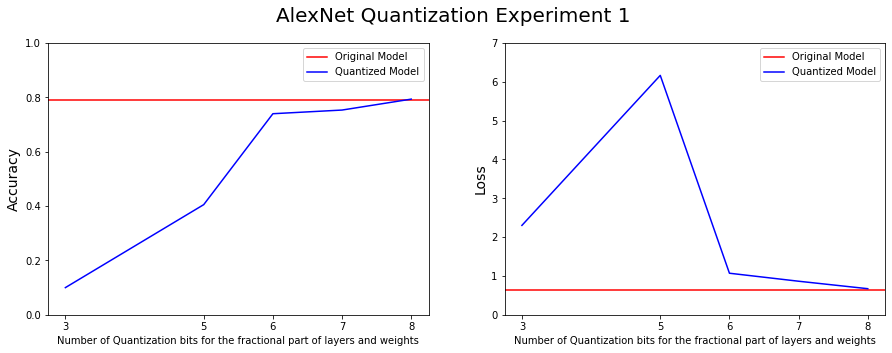

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('AlexNet Quantization Experiment 1',fontsize=20)

Acc  = [0.1, 0.4053, 0.7398, 0.7533, 0.7935]
Qbits = [3, 5, 6, 7, 8]

axs[0].set_xticks(Qbits)
axs[0].set_ylim([0, 1])
axs[0].set_xlabel('Number of Quantization bits for the fractional part of layers and weights')
axs[0].set_ylabel('Accuracy',fontsize=14)
axs[0].axhline(y=0.7898, color='r', linestyle='-')
axs[0].plot(Qbits,Acc, color = 'b', linestyle='-')
axs[0].legend(('Original Model','Quantized Model'))

Loss = [2.3025851249694824, 6.166052489484474, 1.0706737461386249, 0.8646249719636515, 0.6723387817996089]

axs[1].set_xticks(Qbits)
axs[1].set_ylim([0, 7])
axs[1].set_xlabel('Number of Quantization bits for the fractional part of layers and weights')
axs[1].set_ylabel('Loss',fontsize=14)
axs[1].axhline(y=0.6315659527876948, color='r', linestyle='-')
axs[1].plot(Qbits,Loss, color = 'b', linestyle='-')
axs[1].legend(('Original Model','Quantized Model'))

fig.savefig('Figuras/Experimentos_Cuantizacion/ALexNet Quantization Experiment 1.png')

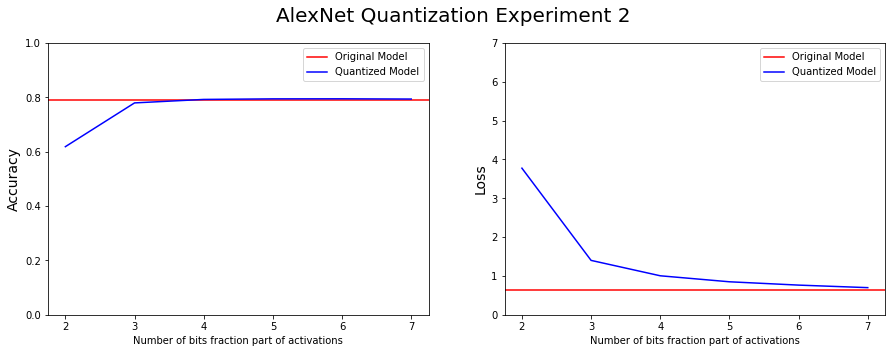

In [10]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('AlexNet Quantization Experiment 2',fontsize=20)

Acc  = [0.6186, 0.7796, 0.7924, 0.7945, 0.7947, 0.7938]
Qbits = [2, 3, 4, 5, 6, 7]

axs[0].set_xticks(Qbits)
axs[0].set_ylim([0, 1])
axs[0].set_xlabel('Number of bits fraction part of activations')
axs[0].set_ylabel('Accuracy',fontsize=14)
axs[0].axhline(y=0.7898, color='r', linestyle='-')
axs[0].plot(Qbits,Acc, color = 'b', linestyle='-')
axs[0].legend(('Original Model','Quantized Model'))

Loss = [3.776289973831177, 1.401272422876954, 1.0048045276381075, 0.8503479480508714, 0.7646517137991266, 0.6994086616043934]

axs[1].set_xticks(Qbits)
axs[1].set_ylim([0, 7])
axs[1].set_xlabel('Number of bits fraction part of activations')
axs[1].set_ylabel('Loss',fontsize=14)
axs[1].axhline(y=0.6315659527876948, color='r', linestyle='-')
axs[1].plot(Qbits,Loss, color = 'b', linestyle='-')
axs[1].legend(('Original Model','Quantized Model'))

fig.savefig('Figuras/Experimentos_Cuantizacion/AlexNet Quantization Experiment 2.png')

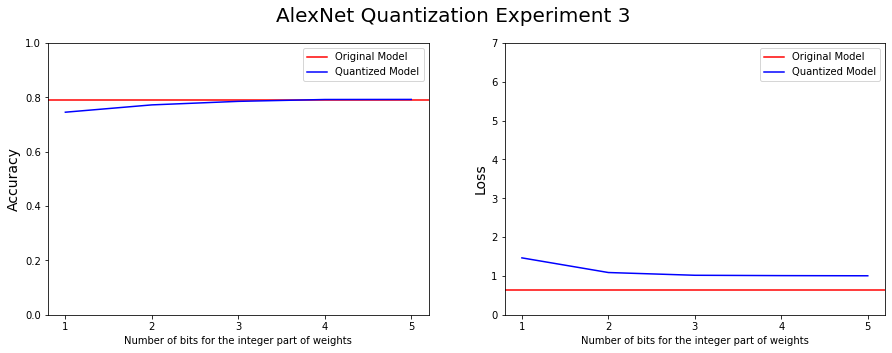

In [11]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('AlexNet Quantization Experiment 3',fontsize=20)

Acc  = [0.7454, 0.7723, 0.7853, 0.7921, 0.7924]
Qbits = [1, 2, 3, 4, 5]

axs[0].set_xticks(Qbits)
axs[0].set_ylim([0, 1])
axs[0].set_xlabel('Number of bits for the integer part of weights')
axs[0].set_ylabel('Accuracy',fontsize=14)
axs[0].axhline(y=0.7898, color='r', linestyle='-')
axs[0].plot(Qbits,Acc, color = 'b', linestyle='-')
axs[0].legend(('Original Model','Quantized Model'))

Loss = [1.466126222857833, 1.0887096228919924, 1.0180256422705949, 1.0091007089659572, 1.0048045276381075]

axs[1].set_xticks(Qbits)
axs[1].set_ylim([0, 7])
axs[1].set_xlabel('Number of bits for the integer part of weights')
axs[1].set_ylabel('Loss',fontsize=14)
axs[1].axhline(y=0.6315659527876948, color='r', linestyle='-')
axs[1].plot(Qbits,Loss, color = 'b', linestyle='-')
axs[1].legend(('Original Model','Quantized Model'))

fig.savefig('Figuras/Experimentos_Cuantizacion/AlexNet Quantization Experiment 3.png')

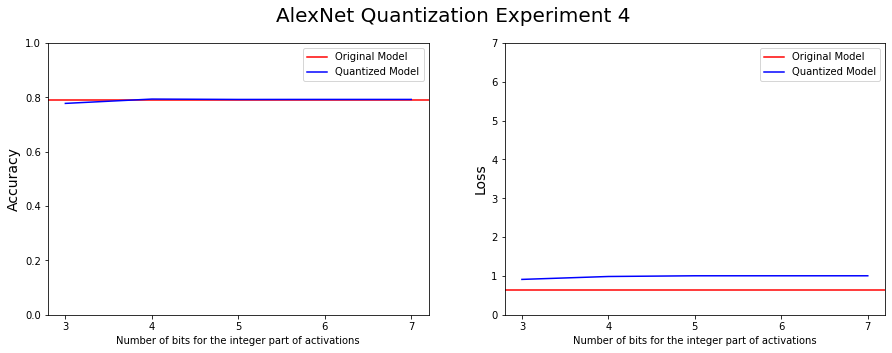

In [12]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('AlexNet Quantization Experiment 4',fontsize=20)

Acc  = [0.7778, 0.7937, 0.7923, 0.7924, 0.7924]
Qbits = [3, 4, 5, 6, 7]

axs[0].set_xticks(Qbits)
axs[0].set_ylim([0, 1])
axs[0].set_xlabel('Number of bits for the integer part of activations')
axs[0].set_ylabel('Accuracy',fontsize=14)
axs[0].axhline(y=0.7898, color='r', linestyle='-')
axs[0].plot(Qbits,Acc, color = 'b', linestyle='-')
axs[0].legend(('Original Model','Quantized Model'))

Loss = [0.9116993742294609, 0.986574599121511, 1.0048096896000207, 1.0048045276381075, 1.0048045276381075]

axs[1].set_xticks(Qbits)
axs[1].set_ylim([0, 7])
axs[1].set_xlabel('Number of bits for the integer part of activations')
axs[1].set_ylabel('Loss',fontsize=14)
axs[1].axhline(y=0.6315659527876948, color='r', linestyle='-')
axs[1].plot(Qbits,Loss, color = 'b', linestyle='-')
axs[1].legend(('Original Model','Quantized Model'))

fig.savefig('Figuras/Experimentos_Cuantizacion/AlexNet Quantization Experiment 4.png')

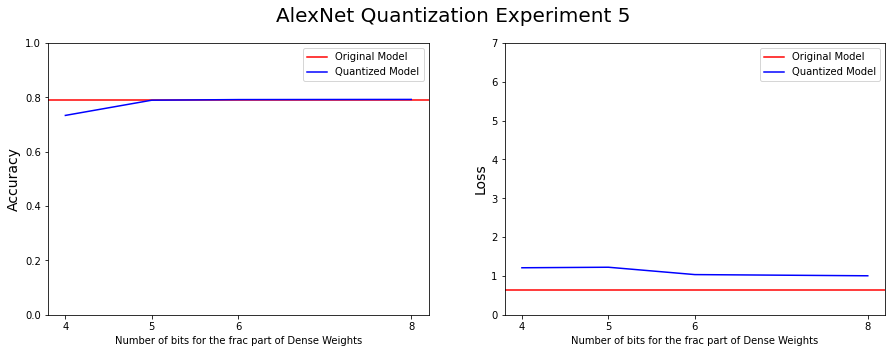

In [13]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('AlexNet Quantization Experiment 5',fontsize=20)

Acc  = [0.7336, 0.7896, 0.7918, 0.7924]
Qbits = [4, 5, 6, 8]

axs[0].set_xticks(Qbits)
axs[0].set_ylim([0, 1])
axs[0].set_xlabel('Number of bits for the frac part of Dense Weights')
axs[0].set_ylabel('Accuracy',fontsize=14)
axs[0].axhline(y=0.7898, color='r', linestyle='-')
axs[0].plot(Qbits,Acc, color = 'b', linestyle='-')
axs[0].legend(('Original Model','Quantized Model'))

Loss = [1.2113528115950525, 1.2250263604424894, 1.0354409900657833, 1.0048045276381075]

axs[1].set_xticks(Qbits)
axs[1].set_ylim([0, 7])
axs[1].set_xlabel('Number of bits for the frac part of Dense Weights')
axs[1].set_ylabel('Loss',fontsize=14)
axs[1].axhline(y=0.6315659527876948, color='r', linestyle='-')
axs[1].plot(Qbits,Loss, color = 'b', linestyle='-')
axs[1].legend(('Original Model','Quantized Model'))

fig.savefig('Figuras/Experimentos_Cuantizacion/AlexNet Quantization Experiment 5.png')